# *Setting Up*

Importing needed libraries and disable convergence warning for logistic regression.

In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


/kaggle/input/seattle_rain_train.csv
/kaggle/input/baseline_submission.csv
/kaggle/input/seattle_rain_test.csv


In [ ]:
# !pip install -q --user kaggle>=1.5.0
# !kaggle competitions download -c sp20-csestat-416-hw-5
# !wget https://raw.githubusercontent.com/valentina-s/cse-stat-416-sp20/master/data/seattle_rain_train.csv
# !wget https://raw.githubusercontent.com/valentina-s/cse-stat-416-sp20/master/data/seattle_rain_test.csv

Import the rain data for training and final output.

Setting up data feature and targets based on test set since train set has extra fields.

Split train data into 80% train and 20% validation.

In [4]:
df_train = pd.read_csv('/kaggle/input/seattle_rain_train.csv')
test_data = pd.read_csv('/kaggle/input/seattle_rain_test.csv')

# data transformation
def transform(data):
    # transform Fahrentheit to Celsius 
    data['TMAX_C'] = (data['TMAX']-32)*5/9
    data['TMIN_C'] = (data['TMIN']-32)*5/9
    data['TMIDR_C'] = (data['TMAX_C']+data['TMIN_C'])/2
    data['TRANGE_C'] = data['TMAX_C']-data['TMIN_C']
    # get all temperature features' square roots
    data['SQRT_TMAX'] = data['TMAX']**0.5
    data['SQRT_TMIN'] = data['TMIN']**0.5
    data['SQRT_TMIDR'] = data['TMIDR']**0.5
    data['SQRT_TRANGE'] = data['TRANGE']**0.5
#     # Celsius square roots doesn't work since some of them are imaginary
#     data['SQRT_TMAX_C'] = data['TMAX_C']**0.5
#     data['SQRT_TMIN_C'] = data['TMIN_C']**0.5
#     data['SQRT_TMIDR_C'] = data['TMIDR_C']**0.5
#     data['SQRT_TRANGE_C'] = data['TRANGE_C']**0.5
    # transfer month and season into percentage
    data['MONTH_PER'] = data['MONTH']/12
    data['SEASON_PER'] = data['SEASON']/4

# # finally decided not to transform data
# transform(df_train)
# transform(test_data)

print(list(df_train.columns))
print(list(test_data.columns))

train_data, validation_data = train_test_split(df_train, test_size = 0.2, random_state = 1)
print("train size =", len(train_data))
print("validation size =", len(validation_data))
print("test size =", len(test_data))
features = [
    'PRCP',
    'TMAX',
    'TMIN',
    'RAIN',
    'TMIDR',
    'TRANGE',
    'MONTH',
    'SEASON',
    'YEST_RAIN',
    'YEST_PRCP',
    'SUM7_PRCP',
    'SUM14_PRCP',
    'SUM30_PRCP'
]
all_features = features+[
    'TMAX_C',
    'TMIN_C',
    'TMIDR_C',
    'TRANGE_C',
    'SQRT_TMAX',
    'SQRT_TMIN',
    'SQRT_TMIDR',
    'SQRT_TRANGE',
    'MONTH_PER',
    'SEASON_PER'
]
target = 'TMRW_RAIN' 
train_data.head()

['DATE', 'PRCP', 'TMAX', 'TMIN', 'RAIN', 'TMIDR', 'TRANGE', 'MONTH', 'SEASON', 'TMRW_RAIN', 'TMRW_PRCP', 'YEST_RAIN', 'YEST_PRCP', 'SUM7_PRCP', 'SUM14_PRCP', 'SUM30_PRCP']
['Id', 'PRCP', 'TMAX', 'TMIN', 'RAIN', 'TMIDR', 'TRANGE', 'MONTH', 'SEASON', 'YEST_RAIN', 'YEST_PRCP', 'SUM7_PRCP', 'SUM14_PRCP', 'SUM30_PRCP']
train size = 15171
validation size = 3793
test size = 6557


,DATE,PRCP,TMAX,TMIN,RAIN,TMIDR,TRANGE,MONTH,SEASON,TMRW_RAIN,TMRW_PRCP,YEST_RAIN,YEST_PRCP,SUM7_PRCP,SUM14_PRCP,SUM30_PRCP
8819,1972-03-23,0.00,51,37,0,44.0,14,3,1,1.0,0.25,1.0,0.22,0.56,2.48,10.83
1649,1952-08-05,0.00,68,55,0,61.5,13,8,3,0.0,0.00,0.0,0.00,0.00,0.06,0.41
9434,1973-11-28,0.61,56,44,1,50.0,12,11,4,1.0,0.14,1.0,0.34,2.05,3.72,8.50
16484,1993-03-18,0.01,50,43,1,46.5,7,3,1,1.0,0.10,0.0,0.00,1.06,1.11,2.47
10760,1977-07-16,0.03,69,54,1,61.5,15,7,3,0.0,0.00,0.0,0.00,0.26,0.39,0.42


Plotting to sea weights and importances of all features (including transformed ones). The result didn't show that transformed ones are necessarily more important, so I decided not to use them and stick with original features.

In [ ]:
coef = abs(LogisticRegression(penalty='l2',C=1,random_state=0).fit(train_data[all_features], train_data[target]).coef_[0])
coef_2 = abs(LogisticRegression(penalty='l2',C=10**3,random_state=0).fit(train_data[all_features], train_data[target]).coef_[0])
coef_3 = abs(LogisticRegression(penalty='l2',C=10**6,random_state=0).fit(train_data[all_features], train_data[target]).coef_[0])
importance = RandomForestClassifier(random_state=0).fit(train_data[all_features], train_data[target]).feature_importances_
importance_2 = RandomForestClassifier(max_depth=3, random_state=0).fit(train_data[all_features], train_data[target]).feature_importances_
importance_3 = RandomForestClassifier(max_depth=5, random_state=0).fit(train_data[all_features], train_data[target]).feature_importances_

fig, axs = plt.subplots(2, 3, figsize=(23, 20))
axs[0,0].barh(all_features, coef, align="center")
axs[0,0].set_title("Feature importances(Log 1)")
axs[0,1].barh(all_features, coef_2, align="center")
axs[0,1].set_title("Feature importances(Log 2)")
axs[0,2].barh(all_features, coef_3, align="center")
axs[0,2].set_title("Feature importances(Log 2)")
axs[1,0].barh(all_features, importance, align="center")
axs[1,0].set_title("Feature importances(RF 1)")
axs[1,1].barh(all_features, importance_2, align="center")
axs[1,1].set_title("Feature importances(RF 2)")
axs[1,2].barh(all_features, importance_3, align="center")
axs[1,2].set_title("Feature importances(RF 3)")

Define a helper method to print train and validation accuracies, then show the scores of the models.

In [7]:
def print_score(classifier, name):
    train_preds = classifier.predict(train_data[features])
    validation_preds = classifier.predict(validation_data[features])
    train_accuracy = accuracy_score(train_data[target], train_preds)
    validation_accuracy = accuracy_score(validation_data[target], validation_preds)
    print(name, "train accuracy =", train_accuracy)
    print(name, "validation accuracy =", validation_accuracy)
    print()

# *Submission ver.1*
Try out some classifiers to see which one works better (set with fixed random state to exclude randomness).

Models including: random forest, decision tree, logistic regression.

In [ ]:
rt = RandomForestClassifier(max_depth=2, random_state=0)
rt.fit(train_data[features], train_data[target])

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(train_data[features], train_data[target])

log = LogisticRegression(random_state=0).fit(train_data[features], train_data[target])

Based on the validation accuracy, random forest seems to be the best.

In [ ]:
print_score(rt, "random forest")
print_score(tree, "tree")
print_score(log, "logistic")

Since random forest performs the best on validation set, we then want to see its performance on different depths.

Using decision as comparsion to see the detailed difference on performance.

Finally, plot the data of the models to visualize.

In [ ]:
depths = list(range(1, 26, 2))
dt_accuracies = []
rf_accuracies = []

for i in depths:
    print(f'Depth {i}')
    tree = DecisionTreeClassifier(max_depth=i,random_state=0)
    tree.fit(train_data[features], train_data[target])

    dt_accuracies.append((
        accuracy_score(tree.predict(train_data[features]), train_data[target]),
        accuracy_score(tree.predict(validation_data[features]), validation_data[target])
    ))
    
    
    rf = RandomForestClassifier(max_depth=i,random_state=0)
    rf.fit(train_data[features], train_data[target])
    
    rf_accuracies.append((     
        accuracy_score(rf.predict(train_data[features]), train_data[target]),
        accuracy_score(rf.predict(validation_data[features]), validation_data[target])
    ))
    
# plotting data
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(depths, [acc[0] for acc in dt_accuracies], label='Train Data')
axs[0].plot(depths, [acc[1] for acc in dt_accuracies], label='Validation Data')

axs[1].plot(depths, [acc[0] for acc in rf_accuracies], label='Train Data')
axs[1].plot(depths, [acc[1] for acc in rf_accuracies], label='Validation Data')

# Customize plots
axs[0].set_title('DecisionTree')
axs[1].set_title('RandomForest')
for ax in axs:
    ax.legend()
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('Accuracy')

Using grid search to confirm the best depth.

{'max_depth': 5, 'min_samples_leaf': 300}
gridCV train accuracy = 0.7161690066574385
gridCV validation accuracy = 0.7181650408647509



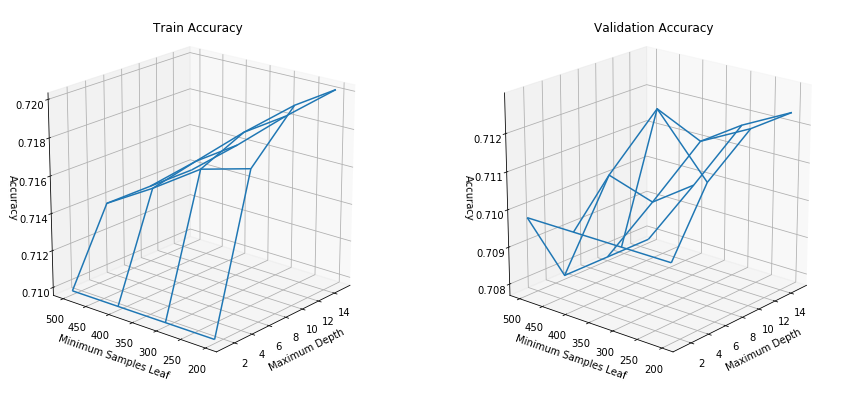

In [17]:
hyperparameters = {'min_samples_leaf': [200, 300, 400, 500], 'max_depth': [1, 5, 10, 15]}
search = GridSearchCV(DecisionTreeClassifier(random_state=0), hyperparameters, cv=10, return_train_score=True)
search.fit(train_data[features], train_data[target])
print(search.best_params_)
print_score(search, "gridCV")

def plot_scores(ax, title, search, hyperparameters, score_key):
    cv_results = search.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape((len(hyperparameters['max_depth']), len(hyperparameters['min_samples_leaf'])))
    max_depths = cv_results['param_max_depth'].reshape(scores.shape).data.astype(int)
    min_samples_leafs = cv_results['param_min_samples_leaf'].reshape(scores.shape).data.astype(int)
    
    ax.plot_wireframe(max_depths, min_samples_leafs, scores)
    ax.view_init(20, 220)
    ax.set_xlabel('Maximum Depth')
    ax.set_ylabel('Minimum Samples Leaf')
    ax.set_zlabel('Accuracy')
    ax.set_title(title)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_scores(ax1, 'Train Accuracy', search, hyperparameters, 'mean_train_score')
plot_scores(ax2, 'Validation Accuracy', search, hyperparameters, 'mean_test_score')

# *Submission ver.2*
After the first submission, I decided to try out some other models to see if they work better.

New models including: ada boost, gradient boost.

In [ ]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=100, random_state=0)
ada.fit(train_data[features], train_data[target])

grad = GradientBoostingClassifier(n_estimators=100, random_state=0)
grad.fit(train_data[features], train_data[target])

print_score(ada, "ada")
print_score(grad, "gradient")

See when does the models overfit with increasing estimators.

In [ ]:
n_estimators=[1,2,4,10,20,50,100,200,300,500]
ada_accuracies=[]
grad_accuracies=[]
for i in n_estimators:
    print(f'Estimators {i}')
    a = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=i,random_state=0)
    a.fit(train_data[features], train_data[target])

    ada_accuracies.append((
        accuracy_score(a.predict(train_data[features]), train_data[target]),
        accuracy_score(a.predict(validation_data[features]), validation_data[target])
    ))

    g = GradientBoostingClassifier(n_estimators=i,random_state=0)
    g.fit(train_data[features], train_data[target])

    grad_accuracies.append((
        accuracy_score(g.predict(train_data[features]), train_data[target]),
        accuracy_score(g.predict(validation_data[features]), validation_data[target])
    ))


Plot the data to visualize.

It turned out ada boost overfits very fast as number of estimators increases, on the other hand, gradient boost barely overfits and maintain a decent accuracy on validation set.

In [ ]:
# plotting data
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(n_estimators, [acc[0] for acc in ada_accuracies], label='Train Data')
axs[0].plot(n_estimators, [acc[1] for acc in ada_accuracies], label='Validation Data')

axs[1].plot(n_estimators, [acc[0] for acc in grad_accuracies], label='Train Data')
axs[1].plot(n_estimators, [acc[1] for acc in grad_accuracies], label='Validation Data')

# Customize plots
axs[0].set_title('AdaBoost')
axs[1].set_title('GradientBoost')
for ax in axs:
    ax.legend()
    ax.set_xlabel('Num Estimators')
    ax.set_ylabel('Accuracy')

# *Submission ver.3*
After the second submission, I did a bit of research on sklearn website and found the stacking classifier, which takes in predictions of multiple estimators and weights them to produce final results using the final estimator.

Based on the tutorial, by taking another stacking classifier as the final estimator, it's possible to create multiple layers like a neuro network, which might better analyze the data and produce more precise output, so I decided to go with this model.

1. The first layer consists: random forest, gradient boost; these two are the best performing models in the previous submissions, so I chose them to be the main processing part.

2. The second layer consists: ridge classifier, logistic regression, SVC; it's designed to analyze the prediction of random forest and gradient boosting in different ways and also see which one's prediction is more important.

3. The final layer is a logistic regression; it's there to decide which prediction of the estimators is more important and produces the final output.

In [ ]:
final_layer = StackingClassifier(
    estimators=[('ridge', RidgeClassifier()),
                ('log', LogisticRegression(random_state=0)),
                ('svc', SVC(C=1, gamma=1e-6, kernel='rbf'))],
                final_estimator=LogisticRegression(random_state=0)
)
multi_layer_Classifier = StackingClassifier(
    estimators=[('rf', RandomForestClassifier(max_depth=5,random_state=0)),
                ('gbrt', GradientBoostingClassifier(random_state=0))],
                final_estimator=final_layer
)
multi_layer_Classifier.fit(train_data[features], train_data[target])

After fitting the model, prints out the scores.

The model seems to work fairly decent comparing to previous models.

In [ ]:
print_score(multi_layer_Classifier, "multi layer")

Perform a simple search of different penalty to see when does the model work best.

After narrowing down the penalty 3 times, C=30 seems to work best on validation set.

In [ ]:
multi_accuracies=[]
# first try
C_list = [10**j for j in range(-3,6)] 

# # second try
# C_list = [0.75,1,2,3,5,10,20,30,50,75,100,120]

# # third try
# C_list = range(20,51,3)

# # forth try
# C_list = range(26,33)
for C in C_list:
    print("C =",str(C))
    multi = StackingClassifier(
        estimators=[('rf', RandomForestClassifier(max_depth=5,random_state=0)),
                    ('gbrt', GradientBoostingClassifier(random_state=0))],
                    final_estimator=StackingClassifier(
                        estimators=[('ridge', RidgeClassifier(alpha=1 / (2*C))),
                                    ('log', LogisticRegression(C=C,random_state=0)),
                                    ('svc', SVC(C=C, gamma=1e-6, kernel='rbf'))],
                                    final_estimator=LogisticRegression(C=C,random_state=0)
                    )
    )
    multi.fit(train_data[features], train_data[target])
    train_score = accuracy_score(multi.predict(train_data[features]), train_data[target])
    validation_score = accuracy_score(multi.predict(validation_data[features]), validation_data[target])
    multi_accuracies.append((train_score, validation_score))
    print("train accuracy = ",train_score,"\tvalidation accuracy = ",validation_score)

Plotting the data to visualize.

In [ ]:
plt.figure()
plt.plot(range(0,len(C_list)), [acc[0] for acc in multi_accuracies], label='Train Data')
plt.plot(range(0,len(C_list)), [acc[1] for acc in multi_accuracies], label='Validation Data')

# Customize plots
plt.title('Multi Layer')
plt.legend()
plt.xlabel('C')
plt.ylabel('Accuracy')

Using grid search to perform a more detailed hyperparameter tuning. This eventually takes too long to run, so I cancelled it and run my customized search on local.

In [ ]:
multi_layer_Classifier.get_params()

In [ ]:
multi_hyperparameters ={'final_estimator__ridge__alpha':np.logspace(-5,0,3),
                        'final_estimator__log__C':np.logspace(0,3,4),
                        'final_estimator__svc__C':np.logspace(0,3,4),
                        'final_estimator__final_estimator__C':np.logspace(0,3,4)}

search_multi = GridSearchCV(StackingClassifier(
                                estimators=[('rf', RandomForestClassifier(max_depth=5,random_state=0)),
                                            ('gbrt', GradientBoostingClassifier(random_state=0))],
                                            final_estimator=StackingClassifier(
                                                estimators=[('ridge', RidgeClassifier()),
                                                            ('log', LogisticRegression(random_state=0)),
                                                            ('svc', SVC(C=1, gamma=1e-6, kernel='rbf'))],
                                                            final_estimator=LogisticRegression(random_state=0)
                                                )
                                )
                            , multi_hyperparameters, cv=10, return_train_score=True)
search_multi.fit(train_data[features], train_data[target])
print(search_multi.best_params_)
print_score(search_multi, "multi layer gridCV")

**Code run on local. (use R studio to analyz the hyperparameters)**

In [ ]:
%%writefile A5_Rain_Or_Not_Kaggle_local.py
import numpy as np
import pandas as pd
from decimal import Decimal
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import os
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
dir_path = os.path.dirname(os.path.realpath(__file__))
df_train = pd.read_csv(dir_path+'/input/seattle_rain_train.csv')
print(list(df_train.columns))
train_data, validation_data = train_test_split(df_train, test_size = 0.2, random_state = 1)
print("train size =", len(train_data))
print("validation size =", len(validation_data))
features = [
    'PRCP',
    'TMAX',
    'TMIN',
    'RAIN',
    'TMIDR',
    'TRANGE',
    'MONTH',
    'SEASON',
    'YEST_RAIN',
    'YEST_PRCP',
    'SUM7_PRCP',
    'SUM14_PRCP',
    'SUM30_PRCP'
]
target = 'TMRW_RAIN'         

results = pd.DataFrame(columns=['C1','C2','C3','A','Score'])
C1_list = [10**j for j in range(0,4)]
C2_list = [10**j for j in range(0,4)]
C3_list = [10**j for j in range(0,4)]
A_list = [10**-j for j in range(0,11,2)]
try:
    for A in A_list:
        for C1 in C1_list:
            for C2 in C2_list:
                for C3 in C3_list:
                    print("A =",A," C1 =",C1," C2 =",C2," C3 =",C3)
                    multi = StackingClassifier(
                        estimators=[('rf', RandomForestClassifier(max_depth=5,random_state=0)),
                                    ('gbrt', GradientBoostingClassifier(random_state=0))],
                                    final_estimator=StackingClassifier(
                                        estimators=[('ridge', RidgeClassifier(alpha=A)),
                                                    ('log', LogisticRegression(C=C1,random_state=0)),
                                                    ('svc', SVC(C=C2, gamma=1e-6, kernel='rbf'))],
                                                    final_estimator=LogisticRegression(C=C3,random_state=0)
                                    )
                    )
                    multi.fit(train_data[features], train_data[target])
                    train_score = accuracy_score(multi.predict(train_data[features]), train_data[target])
                    validation_score = accuracy_score(multi.predict(validation_data[features]), validation_data[target])
                    print("train accuracy = ",train_score,"\tvalidation accuracy = ",validation_score)
                    results = results.append({'C1':C1, 'C2':C2, 'C3':C3, 'A':A, 'Score':(train_score, validation_score)}, ignore_index=True)
except:
    results.to_csv('results.csv')
else:
    results['val_score']=results['Score'].apply(lambda x: x[1])
    print(results)
    results.to_csv('results.csv')


**R code for visualizing data and further analysis.**

In [ ]:
%%writefile A5_Rain_Or_Not_Kaggle_analyze.r
data <- read.csv("results.csv",header=T)
names(data)
par(mfrow=c(2,2))
for(i in 2:5){
    plot(data[,i],data[,7],ylim = c(min(data[,7]),max(data[,7])))
}

# Submission ver.3
Now including KNN into multi layer model's first layer, and tune for its hyperparameter

In [ ]:
hyperparameters = {'n_neighbors': [20,30,50,75,100],'leaf_size':[5,10,20,30]}
search = GridSearchCV(KNeighborsClassifier(), hyperparameters, cv=10, return_train_score=True)
search.fit(train_data[features], train_data[target])
print(search.best_params_)
print_score(search, "gridCV")

# *ROC Curves Plot*
Using the roc_curve from sklearn library to create the ROC curve for all the models I've used.

Note: all parameters set to default and random_state=0.

In [ ]:
label = validation_data[target]
multi_layer_clf = StackingClassifier(
    estimators=[('rf', RandomForestClassifier(random_state=0)),
                ('gbrt', GradientBoostingClassifier(random_state=0))],
                final_estimator=StackingClassifier(
                    estimators=[('ridge', RidgeClassifier()),
                                ('log', LogisticRegression(random_state=0)),
                                ('svc', SVC(random_state=0))],
                                final_estimator=LogisticRegression(random_state=0)
                )
)

models = [LogisticRegression(random_state=0), 
          DecisionTreeClassifier(random_state=0),
          RandomForestClassifier(random_state=0),
          AdaBoostClassifier(random_state=0),
          GradientBoostingClassifier(random_state=0),
          multi_layer_clf]
names = ["Logistic","Decision Tree","Random Forest","Ada Boost","GradientBoosting","Multi Layer"]
results = pd.DataFrame(columns=['fpr','tpr','auc'])

# fit the models and record fpr, tpr
for clf in models:
    model = clf.fit(train_data[features], train_data[target])
    proba = model.predict_proba(validation_data[features])[:,1]
    fpr, tpr, _ = roc_curve(label, proba)
    auc = roc_auc_score(label, proba)
    results = results.append({'fpr':fpr, 'tpr':tpr, 'auc':auc}, ignore_index=True)

Looking at the plot, all models except decision tree perform about the same, though looking at the AUC, gradient boost seems to be the best, which implies it's really good at predicting positive labels (rain tomorrow). 

However, all the models here haven't get their parameters tuned, so it's hard to tell which one is really the best just based on this plot.

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(results)):
    plt.plot(results.iloc[i]['fpr'], 
             results.iloc[i]['tpr'], 
             label=names[i]+", AUC="+str(round(results.iloc[i]['auc'], 3)))

plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.legend(loc='lower right')
plt.title('ROC Curve')
plt.xlabel("Flase Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")


# *Prepare Submission File*
After looking into the models, use the best parameters to predict the test set and output predictions in csv file

> ***Submission 1***
Using random forest with max_depth = 5 (ver1.1 min_samples_leaf=300)

In [ ]:
final = RandomForestClassifier(max_depth=5,min_samples_leaf=300)
final.fit(train_data[features], train_data[target])
print_score(final, "final")

Based on the histogram, PRCP seems to be most important and RAIN comes second.

In [ ]:
importances = final.feature_importances_
plt.figure()
plt.title("Feature importances")
plt.barh(features, importances, align="center")

Save test predictions as csv file.

In [ ]:
final_predictions = final.predict(test_data[features])
to_save = test_data[['Id']].copy()
to_save.loc[:, 'Category'] = final_predictions.astype(int)
to_save.to_csv('submission.csv', index=False)
print(len(final_predictions))
to_save.head()

> ***Submission 2***
Using gradient boost with optimized n_estimators(ver2.0 n_estimators=300; ver2.1 n_estimators=100)

In [ ]:
finalv2 = GradientBoostingClassifier(n_estimators=100)
finalv2.fit(train_data[features], train_data[target])
print_score(finalv2, "finalv2")

Based on the histogram, PRCP seems to be most important, which is significantly more than others.

In [ ]:
importances = finalv2.feature_importances_
plt.figure()
plt.title("Feature importances")
plt.barh(features, importances, align="center")

Save test predictions as csv file.

In [ ]:
finalv2_predictions = finalv2.predict(test_data[features])
to_save = test_data[['Id']].copy()
to_save.loc[:, 'Category'] = finalv2_predictions.astype(int)
to_save.to_csv('submission_v2.csv', index=False)
print(len(finalv2_predictions))
to_save.head()

> ***Submission 3***
Using multi layer model with optimized penalty (ver3.0 alpha=1/60,C=30; ver3.1 alpha=10**-10,C1=10,C2=100,C3=10)

In [ ]:
f_layer = StackingClassifier(
    estimators=[('ridge', RidgeClassifier(alpha=10**-10)),
                ('log', LogisticRegression(C=10)),
                ('svc', SVC(C=100, gamma=1e-6, kernel='rbf'))],
                final_estimator=LogisticRegression(C=10)
)
finalv3 = StackingClassifier(
    estimators=[('rf', RandomForestClassifier(max_depth=5)),
                ('gbrt', GradientBoostingClassifier())],
                final_estimator=f_layer
)

finalv3.fit(train_data[features], train_data[target])
print_score(finalv3, "finalv3")

Assuming random forest's and gradient boosting's predictions weight the same, PRCP seems to be most important on the histogram.

In [ ]:
estimators = finalv3.estimators_
importances=[sum(x)/2 for x in zip(estimators[0].feature_importances_,estimators[1].feature_importances_)]
plt.figure()
plt.title("Feature importances")
plt.barh(features, importances, align="center")

Save test predictions as csv file.

In [26]:
finalv3_predictions = finalv3.predict(test_data[features])
to_save = test_data[['Id']].copy()
to_save.loc[:, 'Category'] = finalv3_predictions.astype(int)
to_save.to_csv('submission_v3.csv', index=False)
print(len(finalv3_predictions))
to_save.head()

6557


,Id,Category
0,0,0
1,1,1
2,2,1
3,3,1
4,4,0


> ***Submission 4***
Using random forest with max_depth = 5, min_samples_leaf=300, and train with k-fold

In [18]:
finalv4 = RandomForestClassifier(max_depth=5,min_samples_leaf=300)
kf = KFold(n_splits=10)
fold=0
for train_index, test_index in kf.split(df_train):
    finalv4.fit(df_train.iloc[train_index][features], df_train.iloc[train_index][target])
    train_preds = finalv4.predict(df_train.iloc[train_index][features])
    validation_preds = finalv4.predict(df_train.iloc[test_index][features])
    train_accuracy = accuracy_score(df_train.iloc[train_index][target], train_preds)
    validation_accuracy = accuracy_score(df_train.iloc[test_index][target], validation_preds)
    print("\tfold:",fold)
    print("finalv4 train accuracy =", train_accuracy)
    print("finalv4 validation accuracy =", validation_accuracy)
    fold+=1            
print("\nfinalv4 overall accuracy =", accuracy_score(df_train[target], finalv4.predict(df_train[features])))

	fold: 0
finalv4 train accuracy = 0.716294603621023
finalv4 validation accuracy = 0.7232472324723247
	fold: 1
finalv4 train accuracy = 0.7184625300287104
finalv4 validation accuracy = 0.7011070110701108
	fold: 2
finalv4 train accuracy = 0.7171149000996074
finalv4 validation accuracy = 0.7211386399578281
	fold: 3
finalv4 train accuracy = 0.7184039374230972
finalv4 validation accuracy = 0.702161307327359
	fold: 4
finalv4 train accuracy = 0.7184790250761659
finalv4 validation accuracy = 0.7078059071729957
	fold: 5
finalv4 train accuracy = 0.7178345441762363
finalv4 validation accuracy = 0.7114978902953587
	fold: 6
finalv4 train accuracy = 0.7184204359034451
finalv4 validation accuracy = 0.7088607594936709
	fold: 7
finalv4 train accuracy = 0.7161940473400515
finalv4 validation accuracy = 0.7420886075949367
	fold: 8
finalv4 train accuracy = 0.7171900632763065
finalv4 validation accuracy = 0.7141350210970464
	fold: 9
finalv4 train accuracy = 0.7161940473400515
finalv4 validation accuracy = 0

In [19]:
finalv4_predictions = finalv4.predict(test_data[features])
to_save = test_data[['Id']].copy()
to_save.loc[:, 'Category'] = finalv4_predictions.astype(int)
to_save.to_csv('submission_v4.csv', index=False)
print(len(finalv4_predictions))
to_save.head()

6557


,Id,Category
0,0,0
1,1,1
2,2,1
3,3,1
4,4,0


> ***Submission 5***
Using multi layer model with KNN and train with k-fold

In [31]:
f_layer = StackingClassifier(
    estimators=[('ridge', RidgeClassifier(alpha=10**-10)),
                ('log', LogisticRegression(C=10)),
                ('svc', SVC(C=100, gamma=1e-6, kernel='rbf'))],
                final_estimator=LogisticRegression(C=10)
)
finalv5 = StackingClassifier(
    estimators=[('rf', RandomForestClassifier(max_depth=5)),
                ('gbrt', GradientBoostingClassifier()),
                ('knn', KNeighborsClassifier(n_neighbors=100,leaf_size=5))],
                final_estimator=f_layer
)
fold=0
for train_index, test_index in kf.split(df_train):
    print("\tfold:",fold)
    finalv5.fit(df_train.iloc[train_index][features], df_train.iloc[train_index][target])
    train_preds = finalv5.predict(df_train.iloc[train_index][features])
    validation_preds = finalv5.predict(df_train.iloc[test_index][features])
    train_accuracy = accuracy_score(df_train.iloc[train_index][target], train_preds)
    validation_accuracy = accuracy_score(df_train.iloc[test_index][target], validation_preds)
    print("finalv5 train accuracy =", train_accuracy)
    print("finalv5 validation accuracy =", validation_accuracy)
    fold+=1            
print("\nfinalv5 overall accuracy =", accuracy_score(df_train[target], finalv5.predict(df_train[features])))

	fold: 0
finalv5 train accuracy = 0.7247319388293197
finalv5 validation accuracy = 0.7258829731154455
	fold: 1
finalv5 train accuracy = 0.7263725317864885
finalv5 validation accuracy = 0.7063784923563521
	fold: 2
finalv5 train accuracy = 0.7260795687584227
finalv5 validation accuracy = 0.7163943068002109
	fold: 3
finalv5 train accuracy = 0.7259623835471963
finalv5 validation accuracy = 0.7032156035846073
	fold: 4
finalv5 train accuracy = 0.7258612608389969
finalv5 validation accuracy = 0.7157172995780591
	fold: 5
finalv5 train accuracy = 0.7266229200843685
finalv5 validation accuracy = 0.7172995780590717
	fold: 6
finalv5 train accuracy = 0.7267986876025311
finalv5 validation accuracy = 0.7209915611814346
	fold: 7
finalv5 train accuracy = 0.7245722990391376
finalv5 validation accuracy = 0.740506329113924
	fold: 8
finalv5 train accuracy = 0.7245722990391376
finalv5 validation accuracy = 0.7225738396624473
	fold: 9
finalv5 train accuracy = 0.7258026716662761
finalv5 validation accuracy = 

In [ ]:
finalv5_predictions = finalv5.predict(test_data[features])
to_save = test_data[['Id']].copy()
to_save.loc[:, 'Category'] = finalv5_predictions.astype(int)
to_save.to_csv('submission_v5.csv', index=False)
print(len(finalv5_predictions))
to_save.head()

> # Backup data for later use & Testing codes

In [ ]:
backup=[]

In [ ]:
backup.append(multi_accuracies)
backup

In [ ]:
a=[1,2]
b=[10,20]
c=[100,200]
print([sum(x) for x in zip(a, b,c)])
print(round(1.1234561234,3))
np.logspace(-6,0,7)
np.logspace(0,4,5)
np.logspace(-5,0,3)
len([10**-j for j in range(0,11,2)])